In [1]:
import numpy as np
import time
import math
import modules as md
import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches




#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newton

In [2]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;


# PN 

In [3]:
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel + runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
    return a # return acceleration

def JerkPN(r,v,acc,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*acc[i]).sum()                                                  
                vad = (vrel*acc[i]).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*acc[i] + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*acc[i]+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt

# Dissipative Effects 

In [35]:
def accdiss(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector
    #a3 = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0) #Acceleration at each time step    
                a2[i] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi*((runi*vrel).sum()))/(rn**8.0)
                #a3[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(vrel)/(rn**8.0)
                a[i] = a1[i] + a2[i] #+ a3[i] 
                #This is the term that becomes zero in a circular orbit
                #a[i,:] += -(18.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum())/(rn**8.0) #Acceleration at each time step 
    return a # return acceleration


def Jerkdiss(r,v,a,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3)) #Define the Jerk
    Je2 = np.zeros((len(r),3)) #Define the Jerk

    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je1[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( a[i]/rn**8.0 - 8.*((vrel*rrel).sum())*(vrel)/(rn**10.0) )                 
                Je2[i] += - (18.0)*ne[i]*((m[j]**2)/m[i])*((a[i]*((rrel*vrel).sum()) + rrel*((rrel*a[i]).sum() + vn**2))/(rn**10.0) - (10*rrel*(((rrel*vrel).sum())**2))/(rn**12.0))
                Je[i] = Je1[i] + Je2[i]
    return Je;


# PN and Dissipation Integrators 

In [8]:
def HermiteUpdatePNdissdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    aD = accdiss(r, v, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN + aD # current acceleration
    
    aNdot = Jerk(r,v,m)
    aDdot = Jerkdiss(r, v, a, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aDp = accdiss(rp, vp, m, ns)
    ap = aNp + aPNp + aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aDdotp = Jerkdiss(rp, vp, ap, m, ns)
    adotp = aNdotp + aPNdotp +  aDdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    #a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    #a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    #ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    #a2c = a2 + dt*a3    
    #acn = ((ac**2).sum())**(1./2) #dot product
    #a2cn = ((a2c**2).sum())**(1./2)
    #adotpn = ((aTdotp**2).sum())**(1./2)
    #a3n = ((a3**2).sum())**(1./2)
    #dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNdissdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNdissdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [6]:
#Define black holes
bh = md.Particle("BH",10,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
bhbh = md.Binary(bh, bh, bh.radi*7, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 


In [31]:
bh.eta

2234355.8738294537

In [32]:
#Have implemented it, need to check it
timetomerge =  (5/256)*(bhbh.orbd**4)*(c_CU**5)*(1./(bh.mass*bh.mass*(bh.mass+bh.mass)))

print(timetomerge/bhbh.periodct)

#accu = 0.001 #0.0001 Set accuracy parameter
tl = 8*bhbh.periodct #Time of the simulation in [code units]
timelimit = tl #
dt = 0.01 #Guess a timestep
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

1.611963716253267


In [33]:
rPND,vPND,timePND = Hermite4thPNdissdt(bh,bh, bhbh, Nsteps, dt)

No handles with labels found to put in legend.


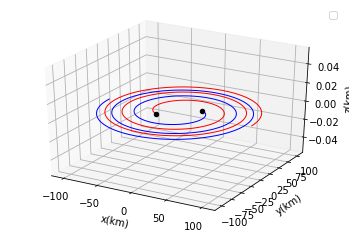

In [34]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPND[0][0], rPND[0][1], rPND[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rPND[1][0], rPND[1][1], rPND[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rPND[0][0][-1], rPND[0][1][-1], rPND[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPND[1][0][-1], rPND[1][1][-1], rPND[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [35]:
rrelPND = rPND[0] - rPND[1]
vrelPND = vPND[0] - vPND[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPND = np.zeros(len(rrelPND .T)) 

for i in range(len(rrelPND.T)):
    dPND[i] = np.linalg.norm(rrelPND.T[i])
    
#Obtain the relative velocity
vnrelPND = np.zeros(len(vrelPND.T))

for i in range(len(rrelPND.T)):
    vnrelPND[i] = np.linalg.norm(vrelPND.T[i])
    
vnrelPNDkm = vnrelPND/kmsec_U*1000/c_SI
timePNDsec = timePND*time_U

In [36]:
print(dPND[-1]/bh.radi)

2.0000371613516963


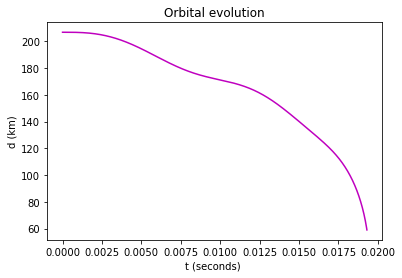

In [38]:
plt.plot(timePNDsec, dPND, '-m')
plt.ylabel('d (km)')
plt.xlabel('t (seconds) ')
#plt.savefig('orbital-evolution', format = 'png', dpi =200)
plt.title('Orbital evolution')
plt.show()

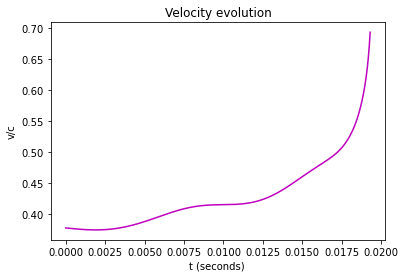

In [39]:
plt.plot(timePNDsec, vnrelPNDkm, '-m')
plt.ylabel('v/c')
plt.xlabel('t (seconds) ')
#plt.savefig('velocity-evolution', format = 'png', dpi =200)
plt.title('Velocity evolution')
plt.show()

In [41]:
wsPND = np.zeros([len(dPND)])

for i in range(len(dPND)):
    wsPND[i] = ((bh.mass+bh.mass)/dPND[i]**3)**(1./2) 
    

hplusPND = np.zeros([len(dPND)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPND)):
    hplusPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPND[i]*timePND[i])
    #hcrossPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*wsPND[i]*timesimtp[i])

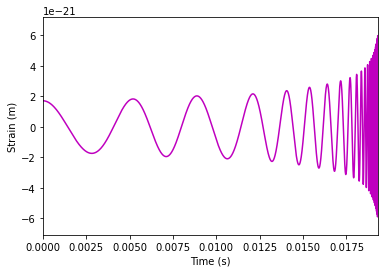

In [42]:
plt.plot(timePNDsec, hplusPND, 'm-')
plt.axis([min(timePND), max(timePNDsec), 1.2*min(hplusPND), 1.2*max(hplusPND)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Only PN 

In [21]:
def HermiteUpdatePNtdt(dt, r, v, m, ns): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp + aPNp #+ aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aDdotp  # predicted jerks 
    
    #compute some other things to find the best value for the timestep
    #Newtonian
    #a2 = (1./dt**2)*(-6*(a-ap)-dt*(4*adot + 2*adotp))
    #a3 = (1./dt**3)*(-12*(a-ap)-6*dt*(adot + adotp))
    #ac = a + adot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3 
    
    #Tides
    #a2 = (1./dt**2)*(-6*(aT-aTp)-dt*(4*aTdot + 2*aTdotp))
    #a3 = (1./dt**3)*(-12*(aT-aTp)-6*dt*(aTdot + aTdotp))
    #ac = aT + aTdot*dt + (1./2)*(dt**2)*a2 + (1./6)*(dt**2)*a3    
    
    #a2c = a2 + dt*a3    
    #acn = ((ac**2).sum())**(1./2) #dot product
    #a2cn = ((a2c**2).sum())**(1./2)
    #adotpn = ((aTdotp**2).sum())**(1./2)
    #a3n = ((a3**2).sum())**(1./2)
    #dtp = (accu*(acn*a2cn + adotpn**2)/(adotpn*a3n + a2cn**2))**(1./2)

    dtp = dt
    
    vp = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rp = r + dt/2*(v + vp) - dt**2/10 * (ap-a)
 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    a_res = a_res[:,:,:i]
    adot_res = adot_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [44]:
#accu = 0.001 #0.0001 Set accuracy parameter
tl = 8*bhbh.periodct #Time of the simulation in [code units]
timelimit = tl #
dt = 0.01 #Guess a timestep
Nsteps = int(tl/dt)

In [45]:
rPN,vPN,timePN, = Hermite4thPNtdt(bh,bh, bhbh, Nsteps, dt)


No handles with labels found to put in legend.


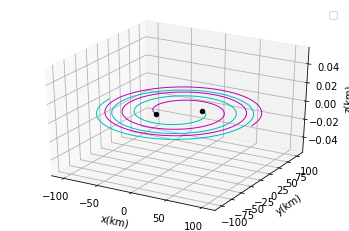

In [46]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPN[0][0], rPN[0][1], rPN[0][2], 'm', linewidth=1)# Plot the BH orbit
ax.plot(rPN[1][0], rPN[1][1], rPN[1][2], 'c', linewidth=1)# Plot the star orbit
ax.scatter3D(rPN[0][0][-1], rPN[0][1][-1], rPN[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPN[1][0][-1], rPN[1][1][-1], rPN[1][2][-1], '0', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')

#plt.savefig('PNcolns.eps', bbox_inches='tight')#, dpi=200
#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', bbox_inches='tight', format='eps')#,

plt.show()

In [47]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])
    
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

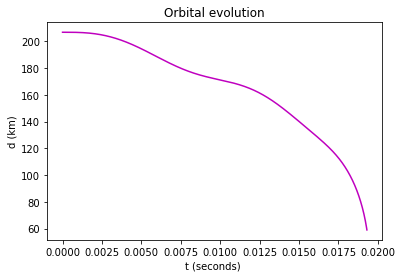

In [49]:
plt.plot(timePNsec, dPN, '-m')
plt.ylabel('d (km)')
plt.xlabel('t (seconds) ')
#plt.savefig('orbital-evolution', format = 'png', dpi =200)
plt.title('Orbital evolution')
plt.show()

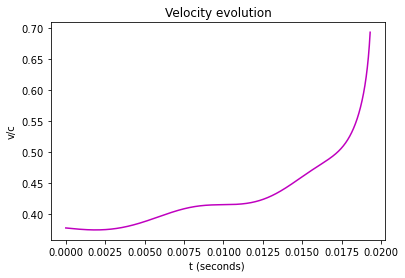

In [50]:
plt.plot(timePNsec, vnrelPNkm, '-m')
plt.ylabel('v/c')
plt.xlabel('t (seconds) ')
#plt.savefig('velocity-evolution', format = 'png', dpi =200)
plt.title('Velocity evolution')
plt.show()

In [51]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((bh.mass+bh.mass)/dPN[i]**3)**(1./2) 
    
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

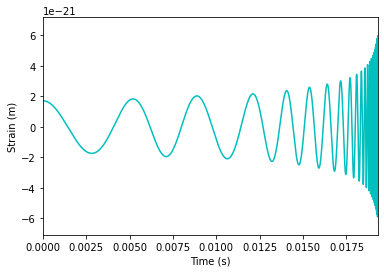

In [52]:
plt.plot(timePNsec, hplusPN, 'c-')
plt.axis([min(timePN), max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of Waveforms 

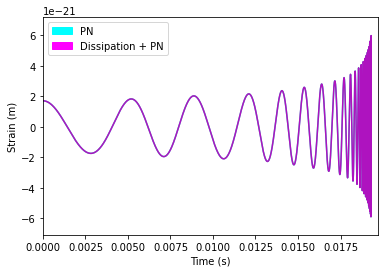

In [53]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'Dissipation + PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timePNDsec, hplusPND, 'm-', alpha = 0.9)
plt.axis([min(timePN), 1.02*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TPNvsPN.eps', bbox_inches='tight') #, dpi=300
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


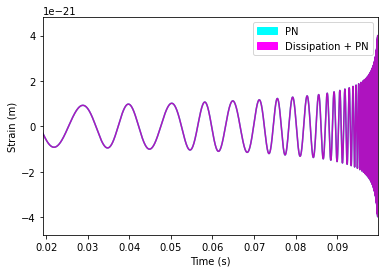

In [33]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'Dissipation + PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timePNDsec, hplusPND, 'm-', alpha = 0.9)
plt.axis([0.01925, 1.0001*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
plt.savefig('gw-DPNvsPN-equalmass.eps', bbox_inches='tight') #, dpi=300
plt.show()

In [60]:
print(timePNsec[-1])
print(timePNDsec[-1])
print(timePNDsec[-1]/timePNsec[-1])

0.019304603164919006
0.01930421879647363
0.9999800892853331


# Unequal mass

In [12]:
#Define black holes
bh = md.Particle("BH",10,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh2 = md.Particle("BH", 20, 0, 0)

#Define binary
bhbh2 = md.Binary(bh2, bh, bh2.radi*7, 0) ##primary, secondary, orbital distance (Rsun), eccentricity 


In [13]:
#accu = 0.001 #0.0001 Set accuracy parameter
tl = 8*bhbh2.periodct #Time of the simulation in [code units]
timelimit = tl #
dt = 0.01 #Guess a timestep
Nsteps = int(tl/dt)

In [14]:
rPND,vPND,timePND = Hermite4thPNdissdt(bh2,bh, bhbh2, Nsteps, dt)

No handles with labels found to put in legend.


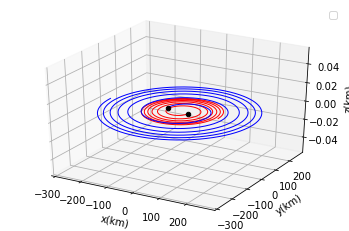

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPND[0][0], rPND[0][1], rPND[0][2], 'r', linewidth=1)# Plot the BH orbit
ax.plot(rPND[1][0], rPND[1][1], rPND[1][2], 'b', linewidth=1)# Plot the star orbit
ax.scatter3D(rPND[0][0][-1], rPND[0][1][-1], rPND[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rPND[1][0][-1], rPND[1][1][-1], rPND[1][2][-1], 'o', c='black') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('PNorbitaldecay.png', format='png', dpi=200)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [16]:
rrelPND = rPND[0] - rPND[1]
vrelPND = vPND[0] - vPND[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPND = np.zeros(len(rrelPND .T)) 

for i in range(len(rrelPND.T)):
    dPND[i] = np.linalg.norm(rrelPND.T[i])
    
#Obtain the relative velocity
vnrelPND = np.zeros(len(vrelPND.T))

for i in range(len(rrelPND.T)):
    vnrelPND[i] = np.linalg.norm(vrelPND.T[i])
    
vnrelPNDkm = vnrelPND/kmsec_U*1000/c_SI
timePNDsec = timePND*time_U

In [17]:
print(dPND[-1])
print(bh.radi + bh2.radi)

88.56833901779575
88.56669967885571


In [18]:
wsPND = np.zeros([len(dPND)])

for i in range(len(dPND)):
    wsPND[i] = ((bh.mass+bh.mass)/dPND[i]**3)**(1./2) 
    

hplusPND = np.zeros([len(dPND)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPND)):
    hplusPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPND[i]*timePND[i])
    #hcrossPND[i] = (1./ro)*(4*mu*(wsPND[i]**2)*(dPND[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*wsPND[i]*timesimtp[i])

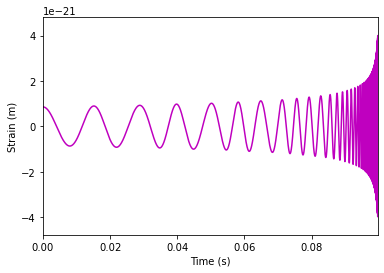

In [19]:
plt.plot(timePNDsec, hplusPND, 'm-')
plt.axis([min(timePND), max(timePNDsec), 1.2*min(hplusPND), 1.2*max(hplusPND)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Only PN 

In [22]:
rPN,vPN,timePN, = Hermite4thPNtdt(bh2,bh, bhbh2, Nsteps, dt)


In [23]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])
    
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

In [24]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((bh.mass+bh.mass)/dPN[i]**3)**(1./2) 
    
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (bh.mass*bh.mass)/(bh.mass+bh.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

# Comparison of Waveforms 

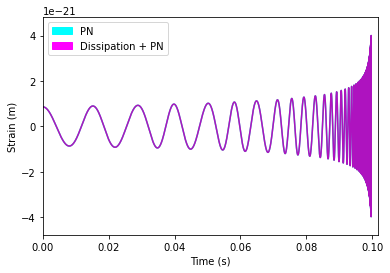

In [25]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'Dissipation + PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timePNDsec, hplusPND, 'm-', alpha = 0.9)
plt.axis([min(timePN), 1.02*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TPNvsPN.eps', bbox_inches='tight') #, dpi=300
plt.show()

/home/irvin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if __name__ == '__main__':
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/irvin/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


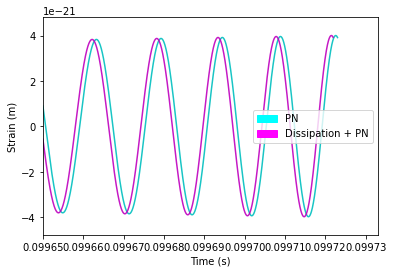

In [32]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN')
magenta_patch = mpatches.Patch(color='magenta', label=r'Dissipation + PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'c-', alpha = 0.9)
plt.plot(timePNDsec, hplusPND, 'm-', alpha = 0.9)
plt.axis([0.09965, 1.0001*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
plt.savefig('gw-DPNvsPN-unequalmass.eps', bbox_inches='tight') #, dpi=300
plt.show()